<a href="https://colab.research.google.com/github/marioTavFer/somePython/blob/main/series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevendo múltiplas séries usando IA no Python

Como podemos realizar a previsão de diversas séries temporais em uma única vez? Realizamos uma aplicação da biblioteca Mlforecast do Python, que oferece diversos modelos e funcionalidade para realizar a previsão de séries temporais utilizando modelos de aprendizado de máquina, em 4 séries de curva de energia horária das 4 regiões do Brasil.

Esse exercício é uma continuação do exercício "[Usando IA para prever o consumo de energia no Brasil com Python](https://analisemacro.com.br/econometria-e-machine-learning/usando-ia-para-prever-o-consumo-de-energia-no-brasil-com-python/)"

## Introdução

Algumas séries temporais são geradas a partir de dados de frequência muito baixa. Esses dados geralmente exibem múltiplas sazonalidades. Por exemplo, dados horários podem exibir padrões repetidos a cada hora (a cada 24 observações) ou a cada dia (a cada 24 * 7, horas por dia, observações). Esse é o caso da carga elétrica. A carga elétrica pode variar por hora, por exemplo, durante as noites, no Brasil, espera-se uma queda no consumo de eletricidade. Mas também, a carga elétrica varia por semana. Talvez no caso brasileiro, fins de semana haja uma queda na atividade elétrica.

Outro aspecto crucial a ser observado em séries temporais de carga de energia é a tendência. No contexto brasileiro, observa-se claramente uma tendência ascendente, em grande parte devido ao contínuo crescimento econômico do país.

Quando lidamos com séries temporais que exibem tais padrões, torna-se imperativo empregar modelos capazes de identificá-los com precisão. Modelos de Machine Learning voltados para análise de Séries Temporais, como LightGBM ou até mesmo Prophet, destacam-se como as opções mais adequadas para abordar esses cenários complexos.

Portanto, neste exercício usamos diferentes modelos com a biblioteca `MLForecast`, tomando como features valores da própria série para prever a carga de energia elétrica das quatro regiões do Brasil separadamente (Norte, Nordeste, Sudeste e Sul).




# Bibliotecas

In [ ]:
# Instala bibliotecas
!pip install -U mlforecast
!pip install -U utilsforecast

In [ ]:
# Carrega bibliotecas iniciais
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utilsforecast.plotting import plot_series
from datetime import datetime
import seaborn as sns
sns.set()

In [ ]:
# Define parâmetros de estilo para o matplotlib
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(10, 8))
plt.rc("font", size=10)

# Dados

Utilizamos os dados de Carga Horária de Eletricidade Nacional medido pela ONS (em MW). Os valores estão em periodicidade horária, de Jan/2021 até Dez/2023. Decidimos usar um período de tempo menor para diminuir o número de observações e facilitar a criação do exemplo, visto que estaremos lidando com quatro séries diferentes.

Vejamos os dados.

In [ ]:
# Cria função para download dos dados
def download_ons(start_year, end_year):

    url = "https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/curva-carga-ho/"

    # Cria uma lista vazia para inserir os nomes dos arquivos
    arquivos = []

    # Define os nomes dos arquivos zipados de acordo com o range de datas
    for ano in range(start_year, end_year + 1):
        arquivos.append(f'CURVA_CARGA_{ano}.csv')

    # Cria uma lista para armazenar os dataframes individuais
    lista_dataframes = []

    for read in arquivos:
        # Lê o arquivo CSV e adiciona o dataframe à lista
        df = pd.read_csv(url + read, sep=';', decimal=',', parse_dates=['din_instante'], encoding='ISO-8859-1')
        lista_dataframes.append(df)

    # Concatena todos os dataframes da lista em um único dataframe
    arquivo_ons = pd.concat(lista_dataframes, ignore_index=True)
    arquivo_ons['val_cargaenergiahomwmed'] = arquivo_ons['val_cargaenergiahomwmed'].astype(float)
    return arquivo_ons

In [ ]:
# Busca os dados de 2021 até 2023
start_year = 2021
end_year = 2023
df_ons = download_ons(start_year, end_year)

In [ ]:
# Realiza o tratamento dos dados
df_ons_se = (
    df_ons
    [['nom_subsistema', 'din_instante', 'val_cargaenergiahomwmed']]
    # Renomeia Colunas
    .rename(columns = {'val_cargaenergiahomwmed' : 'y',
                       'din_instante' : 'ds',
                       'nom_subsistema' : 'unique_id'})
    # Filtra os dados
    .set_index('ds')
    )

# Preenche os valores faltantes usando a interpolação temporal
df_ons_se['y'] = df_ons_se['y'].interpolate(method = 'time')
df_ons_se.reset_index(inplace = True)

In [ ]:
df_ons_se

,ds,unique_id,y
0,2021-01-01 00:00:00,NORTE,5511.801000
1,2021-01-01 00:00:00,NORDESTE,10343.540000
2,2021-01-01 00:00:00,SUL,9060.566986
3,2021-01-01 00:00:00,SUDESTE,33498.352000
4,2021-01-01 01:00:00,NORTE,5470.133000
...,...,...,...
105115,2023-12-31 22:00:00,SUDESTE,38135.522000
105116,2023-12-31 23:00:00,NORTE,6641.410000
105117,2023-12-31 23:00:00,NORDESTE,12144.917000
105118,2023-12-31 23:00:00,SUL,10365.647000


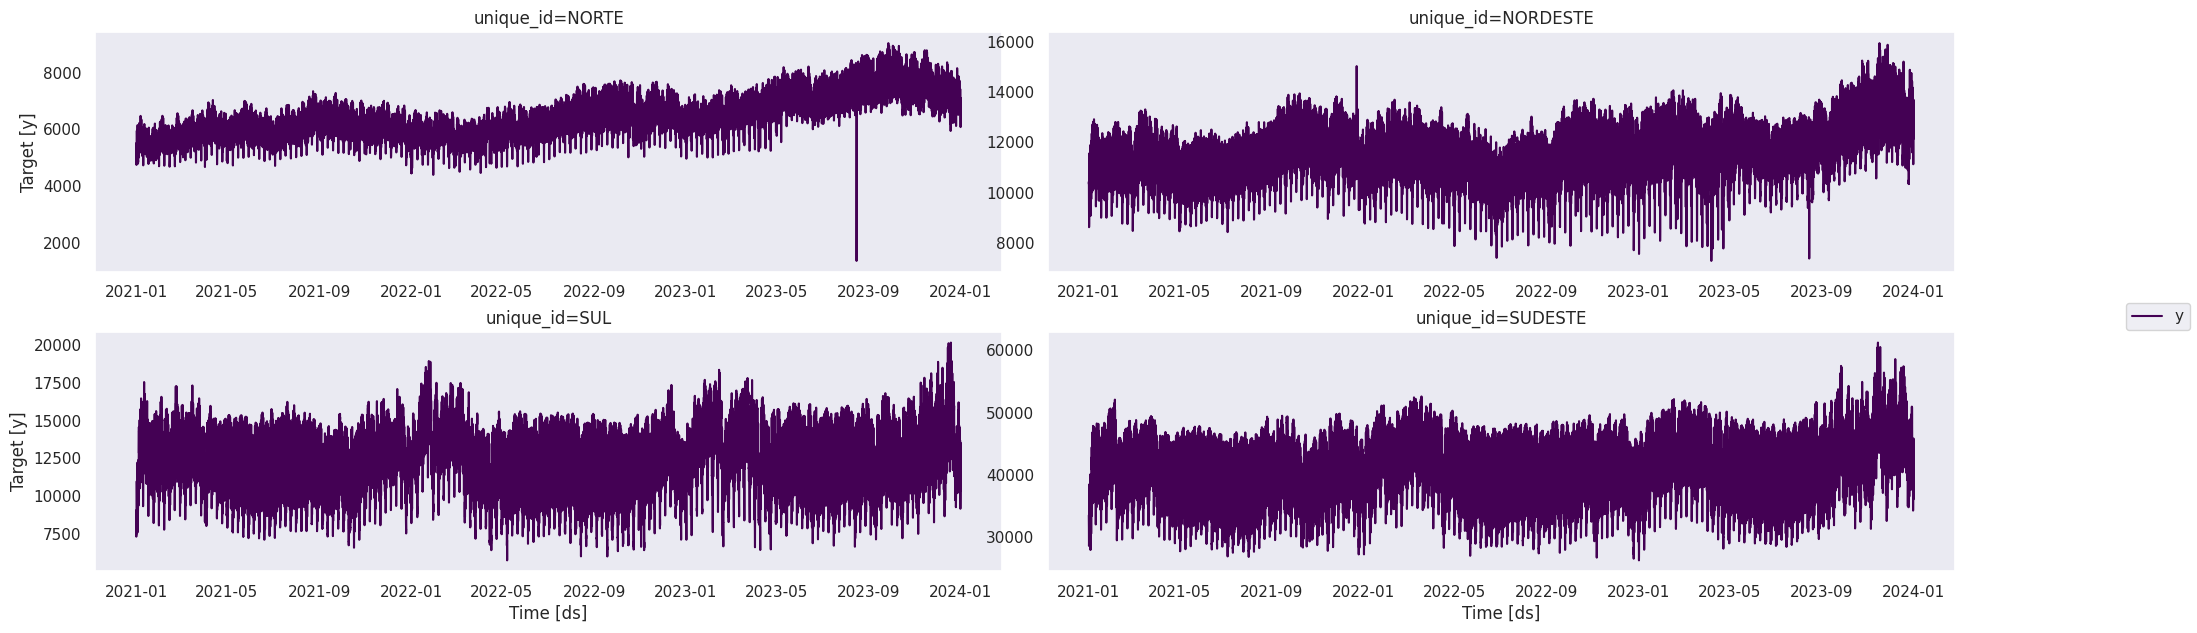

In [ ]:
plot_series(df_ons_se)

Vamos dividir nossa série para criar um conjunto de treinamento e teste. O modelo será testado usando as últimas 24 horas da série temporal.

In [ ]:
# Data máxima menos as últimas 24 horas
threshold_time = df_ons_se['ds'].max() - pd.Timedelta(hours=24)

# Separa o dataframe
df_train = df_ons_se[df_ons_se['ds'] <= threshold_time] # treino
df_last_24_hours = df_ons_se[df_ons_se['ds'] > threshold_time] # teste

,ds,unique_id,y
0,2021-01-01 00:00:00,NORTE,5511.801000
1,2021-01-01 00:00:00,NORDESTE,10343.540000
2,2021-01-01 00:00:00,SUL,9060.566986
3,2021-01-01 00:00:00,SUDESTE,33498.352000
4,2021-01-01 01:00:00,NORTE,5470.133000
...,...,...,...
105019,2023-12-30 22:00:00,SUDESTE,43264.358000
105020,2023-12-30 23:00:00,NORTE,7424.649000
105021,2023-12-30 23:00:00,NORDESTE,14186.032000
105022,2023-12-30 23:00:00,SUL,11823.104000


# Analisando Tendência e Sazonalidades

Primeiro, devemos visualizar a tendência e as sazonalidades do modelo. Como mencionado anteriormente, a carga elétrica apresenta sazonalidades a cada 24 horas (por hora) e a cada 24 * 7 (diariamente) horas. Portanto, usaremos [24, 24 * 7] como as sazonalidades para o modelo. No caso da tendência, supomos que possamos lidar com esse componente através da primeira diferença.

Abaixo, o resultado das séries retirados os respectivos componentes citados anteriormente.

In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences

# Instância com o objeto
fcst = MLForecast(
    models=[],
    freq='H',
    target_transforms=[Differences([1, 24, 24*7])],
)

# Realiza o preprocessamento
prep = fcst.preprocess(df_train)
prep

,ds,unique_id,y
772,2021-01-09 01:00:00,NORTE,13.092000
773,2021-01-09 01:00:00,NORDESTE,425.943000
774,2021-01-09 01:00:00,SUL,528.618992
775,2021-01-09 01:00:00,SUDESTE,900.567000
776,2021-01-09 02:00:00,NORTE,57.879000
...,...,...,...
105019,2023-12-30 22:00:00,SUDESTE,-145.223000
105020,2023-12-30 23:00:00,NORTE,-17.655000
105021,2023-12-30 23:00:00,NORDESTE,94.546000
105022,2023-12-30 23:00:00,SUL,-98.866000


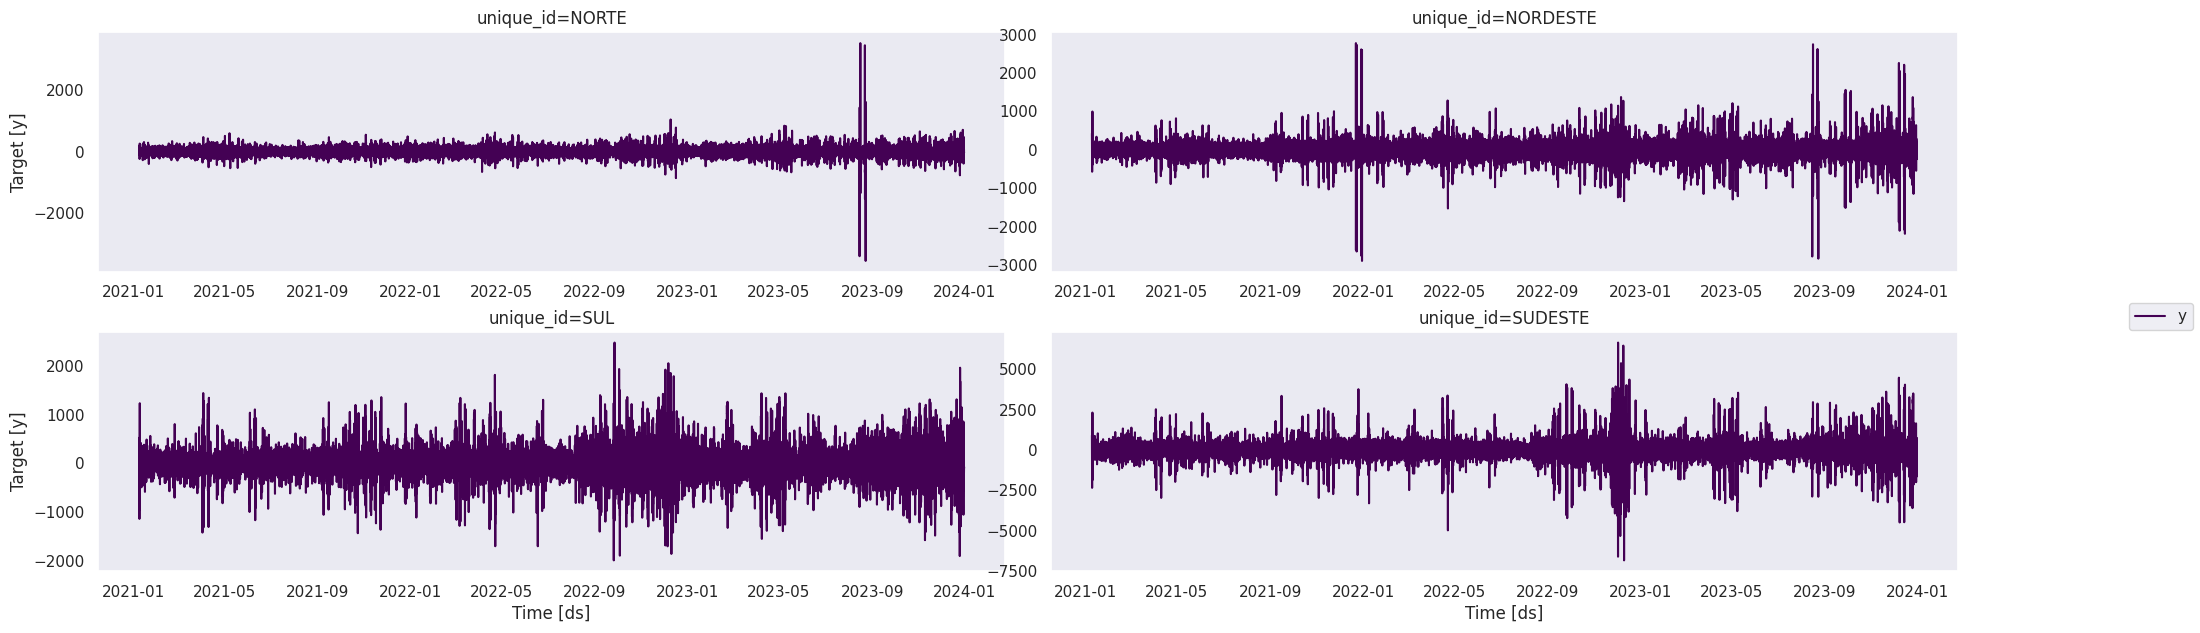

In [ ]:
plot_series(prep)

# Conjunto de Teste

Agora vamos comparar os dados previsto do conjunto de treinamento no conjunto de teste, de forma a compreender qual modelo melhor realizou a previsão. Adicionamos intervalos de confiança para cada previsão. Automaticamente a biblioteca `MlForecast` reconhece as colunas que representam as diferentes séries.

Para tanto, é necessário sempre ter o dataframe em formato long com as colunas no seguintes nomes:
  - y: target, isto é, os valores a serem previstos
  - unique_id: coluna que distigue as diferentes séries (categoriza)
  - ds: coluna de data

Com isso, não necessitamos de nenhuma outra adição nas funções, visto que automaticamente elas reconheceram as colunas. Simples, não?

In [ ]:
# Carrega funções
import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

# Cria modelo ingênuo
class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

# Métricas de acurácia
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

# Carrega função de previsão com intervalos
from mlforecast.utils import PredictionIntervals

In [ ]:
# Dicionário de modelos
models ={
        'naive': Naive(),
        'lgbm': lgb.LGBMRegressor(verbosity=-1),
        'lasso': Lasso(),
        'lin_reg': LinearRegression(),
        'ridge': Ridge(),
        'knn': KNeighborsRegressor(),
        'mlp': MLPRegressor(),
        'rf': RandomForestRegressor()
    }

# Define os lags
lags=[1,12,24]

# Instância objeto de MLForecast
mlf = MLForecast(
    models = models,
    freq='H',
    target_transforms=[Differences([1, 24, 24*7])],
    lags=[1,12,24], # lags a serem utilizados
    # Transformação dos lags
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    # Define os features
    date_features=['month', 'hour', 'dayofweek']
)

# Realiza o ajuste com intervalos
mlf.fit(
    df = df_train,
    prediction_intervals=PredictionIntervals(n_windows=4, h=24)
)

# Define os intervalo e a realiza a previsão
levels = [90, 95] # Levels for prediction intervals
forecasts = mlf.predict(24, level=levels)
forecasts.head()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,unique_id,ds,naive,lgbm,lasso,lin_reg,ridge,knn,mlp,rf,...,knn-hi-90,knn-hi-95,mlp-lo-95,mlp-lo-90,mlp-hi-90,mlp-hi-95,rf-lo-95,rf-lo-90,rf-hi-90,rf-hi-95
0,NORDESTE,2023-12-31 00:00:00,14547.972,14394.339769,14407.803858,14408.021274,14408.021271,14343.678000,14409.331346,14385.939859,...,14915.533769,14930.327884,13943.918492,13956.200400,14862.462292,14874.744200,13940.549941,13941.789872,14830.089846,14831.329777
1,NORDESTE,2023-12-31 01:00:00,14885.826,14411.864860,14413.090257,14413.631955,14413.631944,14107.008600,14444.485323,14437.778879,...,15247.895307,15369.376354,13430.142549,13528.391455,15360.579190,15458.828097,13392.611403,13507.311028,15368.246729,15482.946354
2,NORDESTE,2023-12-31 02:00:00,14653.807,14051.318754,13988.428552,13989.264728,13989.264714,13634.386197,14062.257867,14105.617069,...,14907.223060,14984.428932,12918.755325,12992.094211,15132.421522,15205.760409,12899.845751,13001.305614,15209.928524,15311.388387
3,NORDESTE,2023-12-31 03:00:00,13753.251,13206.797385,13146.516905,13147.621399,13147.621384,12790.347597,13198.152472,13268.817158,...,13711.570552,13724.250178,12372.112820,12379.439431,14016.865513,14024.192125,12517.060107,12522.929556,14014.704760,14020.574209
4,NORDESTE,2023-12-31 04:00:00,13517.971,12928.742713,12897.708529,12899.120264,12899.120246,12544.038597,12910.092395,13005.617098,...,13479.386982,13488.331093,12041.211581,12072.168923,13748.015866,13778.973208,12276.881709,12296.766244,13714.467951,13734.352486


In [ ]:
# Junta os dados do conjunto de teste e a previsão
test = df_last_24_hours.merge(forecasts, how='left', on=['unique_id', 'ds'])
test.head()

,ds,unique_id,y,naive,lgbm,lasso,lin_reg,ridge,knn,mlp,...,knn-hi-90,knn-hi-95,mlp-lo-95,mlp-lo-90,mlp-hi-90,mlp-hi-95,rf-lo-95,rf-lo-90,rf-hi-90,rf-hi-95
0,2023-12-31 00:00:00,NORTE,7412.918,7283.384,7339.650811,7330.406800,7330.569900,7330.569899,7318.4746,7336.855969,...,7493.642966,7499.427434,7171.884433,7177.324409,7496.387529,7501.827506,7164.258726,7183.027165,7468.655737,7487.424176
1,2023-12-31 00:00:00,NORDESTE,13918.433,14547.972,14394.339769,14407.803858,14408.021274,14408.021271,14343.6780,14409.331346,...,14915.533769,14930.327884,13943.918492,13956.200400,14862.462292,14874.744200,13940.549941,13941.789872,14830.089846,14831.329777
2,2023-12-31 00:00:00,SUL,10973.862,11901.228,11617.143586,11672.679514,11672.947897,11672.947891,11745.5310,11818.898271,...,12286.672154,12401.138777,11122.249777,11252.574852,12385.221691,12515.546765,11154.089814,11284.710588,12425.751791,12556.372565
3,2023-12-31 00:00:00,SUDESTE,40009.786,42065.945,41596.227136,41414.524650,41414.833469,41414.833457,41925.3144,41775.852765,...,43030.371653,43211.222435,40452.584836,40674.773427,42876.932102,43099.120693,40484.958309,40678.941137,42876.560244,43070.543072
4,2023-12-31 01:00:00,NORTE,7394.771,7253.388,7285.088038,7269.554906,7269.981618,7269.981613,7255.3282,7277.557965,...,7471.473122,7495.988261,7027.533860,7045.155827,7509.960104,7527.582071,7081.443700,7083.341178,7476.955215,7478.852693


Abaixo, temos os resultados em uma tabela das métricas de acurácia para os valores de cada série e de cada modelo.

In [ ]:
# Métricas utilizadas para a avaliação
metrics = [
    mae,
    rmse,
    mape,
    smape
]

# Avalia as métricas de erros
evaluate(
    df = test,
    metrics=metrics,
    models=list(models.keys())
).style.background_gradient(cmap='RdYlGn_r', axis=1)

,unique_id,metric,naive,lgbm,lasso,lin_reg,ridge,knn,mlp,rf
0,NORDESTE,mae,1490.796208,260.552334,259.249133,257.763883,257.763897,476.142740,249.626545,315.026655
1,NORTE,mae,401.099833,180.122387,143.946101,141.688627,141.688649,258.079474,133.428268,145.559271
2,SUDESTE,mae,1122.636375,1372.930231,799.179935,802.126669,802.126604,1612.941182,639.229794,1436.086474
3,SUL,mae,755.005042,478.748990,422.996475,422.012522,422.012533,1101.849641,512.970826,667.858822
4,NORDESTE,rmse,1646.471680,342.694598,342.037062,340.898625,340.898636,516.382452,336.174652,380.330937
5,NORTE,rmse,437.272296,196.022500,172.224484,170.140118,170.140138,295.569963,165.529778,157.175082
6,SUDESTE,rmse,1372.358273,1639.332685,930.930555,934.540728,934.540642,1956.862432,858.898881,1514.350072
7,SUL,rmse,933.979602,545.661914,507.104849,506.156760,506.156770,1300.795190,680.088205,846.323455
8,NORDESTE,mape,0.120490,0.020879,0.020943,0.020819,0.020819,0.039194,0.020080,0.025185
9,NORTE,mape,0.060352,0.026901,0.021695,0.021341,0.021341,0.038825,0.020046,0.021850


Por fim, podemos comparar o conjunto de teste com os dados preditos de cada modelo. Veja que adicionamos intervalos de previsão.

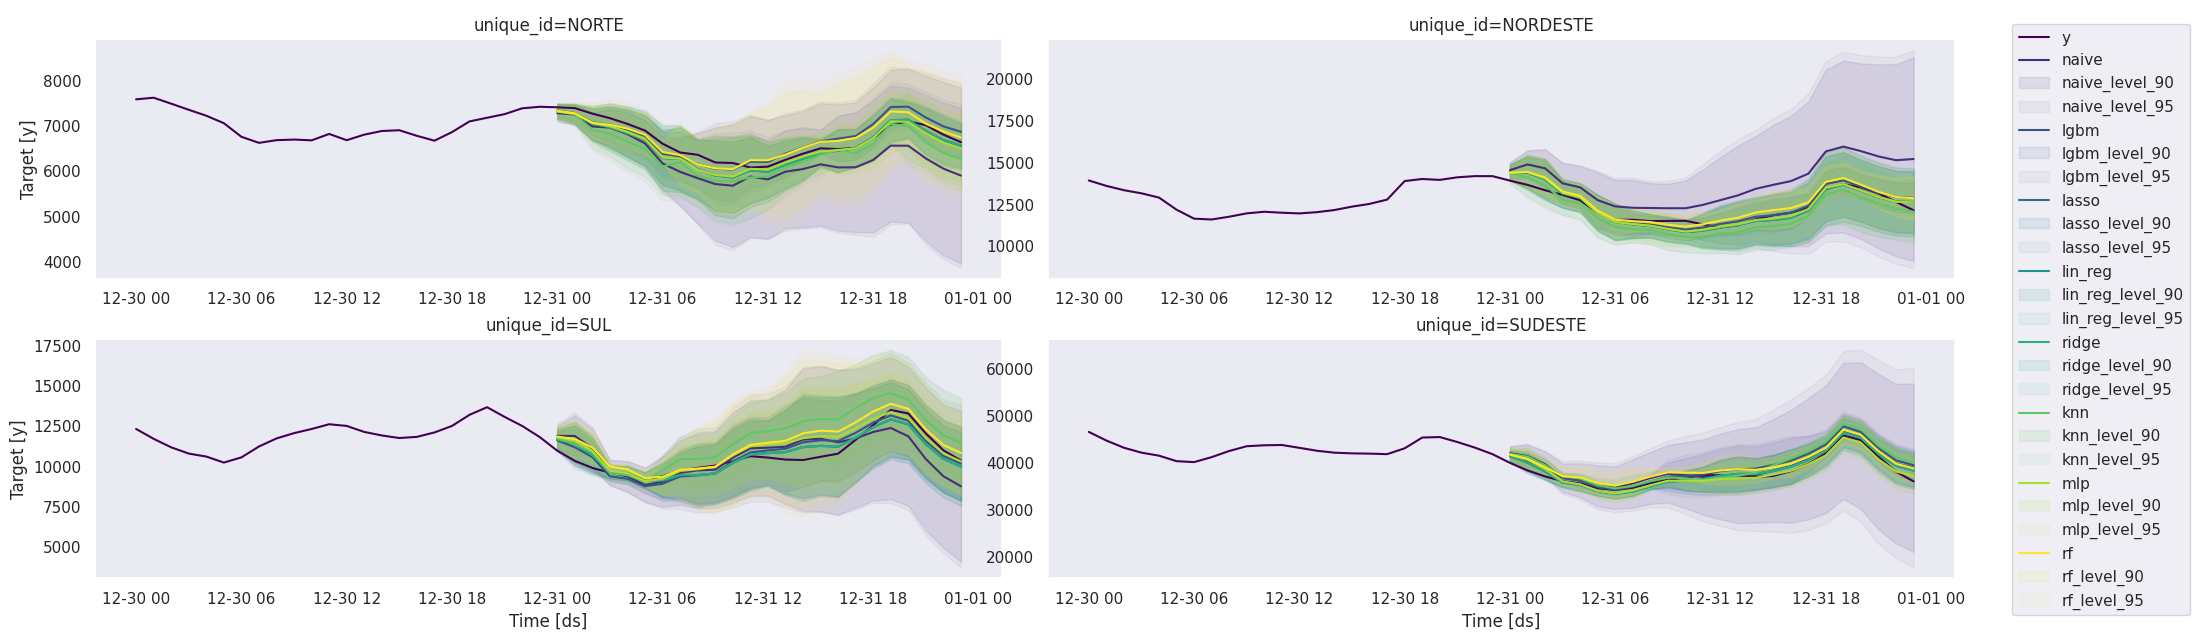

In [ ]:
# Plota a série prevista
plot_series(
    df_train,
    test,
    models=list(models.keys()),
    plot_random=False,
    level=levels,
    max_insample_length=24
)